In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
signal_trees_no_reg = ObjIter(list(map(Tree,fc.eightb.accstudies.raw_no_pu.signal_list)))
signal_trees = ObjIter(list(map(Tree,fc.eightb.accstudies.raw_no_pu.signal_list)))
signal_trees_pu = ObjIter(list(map(Tree,fc.eightb.accstudies.raw_with_pu.signal_list)))

# signal_trees.extend(kwargs=lambda tree : dict(n_ext_jet=tree.n_jet-tree.nfound_presel))
# signal_trees.extend(kwargs=eightb.reco_all)
# signal_trees.extend(kwargs=eightb.reco_res_all)

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


In [3]:
def get_point(label):
    label = label.split('_')
    return str((int(label[1]),int(label[3])))
signal_points = list(map(get_point,signal_trees.sample))

In [4]:
dout = "gen_studies/resonances/"

In [5]:
ylist = [
    f'gen_{y}'
    for y in ('Y1','Y2')
]

higgslist = [
    f'gen_{h}{y}'
    for y in ('Y1','Y2')
    for h in ('H1','H2')
]


quarklist = [
    f'gen_{h}{y}_{b}'
    for y in ('Y1','Y2')
    for h in ('H1','H2')
    for b in ('b1','b2')
]

In [6]:
varinfo.clear()

In [7]:
signal_trees.apply(eightb.reco_all)
signal_trees.apply(eightb.reco_res_all)

[{}, {}, {}]

In [8]:
signal_trees_no_reg.apply(lambda t : eightb.reco_all(t,use_regressed=False))
signal_trees_no_reg.apply(eightb.reco_res_all)

[{}, {}, {}]

In [9]:
signal_trees_pu.apply(eightb.reco_all)
signal_trees_pu.apply(eightb.reco_res_all)


[{}, {}, {}]

In [10]:
def label_resonance(tree):
    tree.extend(
        **{
            f'gen_{resonance}_id': i*ak.ones_like(tree.Run)
            for i, resonance in enumerate(eightb.higgslist)
        },
        **{
            f'gen_{resonance}_id': i*ak.ones_like(tree.Run)
            for i, resonance in enumerate(eightb.ylist)
        },
    )
signal_trees.apply(label_resonance)
signal_trees_pu.apply(label_resonance)
signal_trees_no_reg.apply(label_resonance)


[None, None, None]

In [11]:
signal_trees.gen_H1Y2_id

[<Array [2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2] type='88489 * uint32'>, <Array [2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2] type='92509 * uint32'>, <Array [2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2] type='93812 * uint32'>]

In [12]:
signal_trees.apply(lambda t : build_collection(t,'gen_H\dY\d','gen_higgs', ordered='reco_pt'))
signal_trees_pu.apply(lambda t : build_collection(t,'gen_H\dY\d','gen_higgs', ordered='reco_pt'))
signal_trees_no_reg.apply(lambda t : build_collection(t,'gen_H\dY\d','gen_higgs', ordered='reco_pt'))


[None, None, None]

In [13]:
varinfo.gen_higgs_id = dict(xlabel=[f"gen_{higgs}" for higgs in eightb.higgslist], bins=np.arange(5))

100%|██████████| 5/5 [00:00<00:00, 18.49it/s]


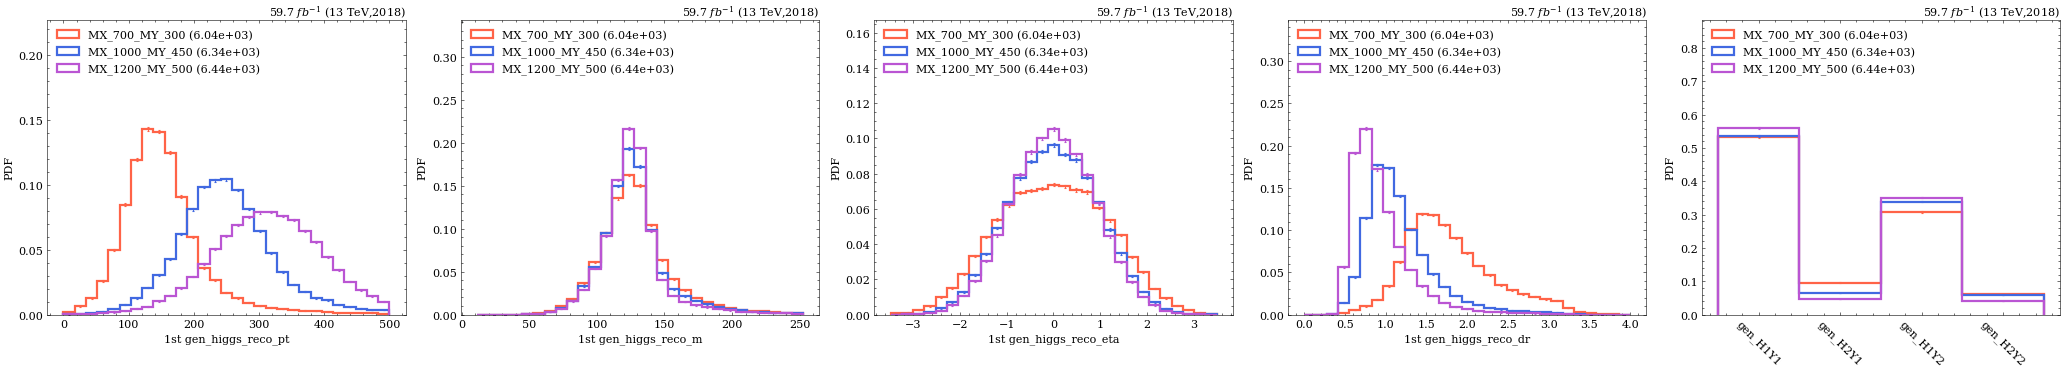

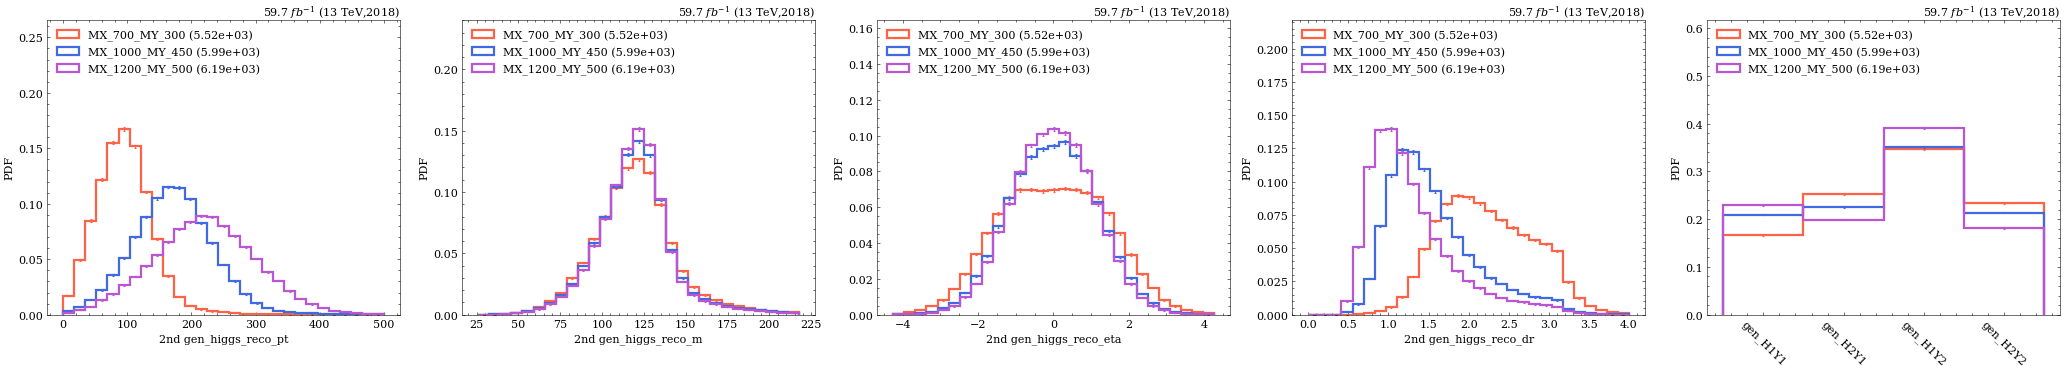

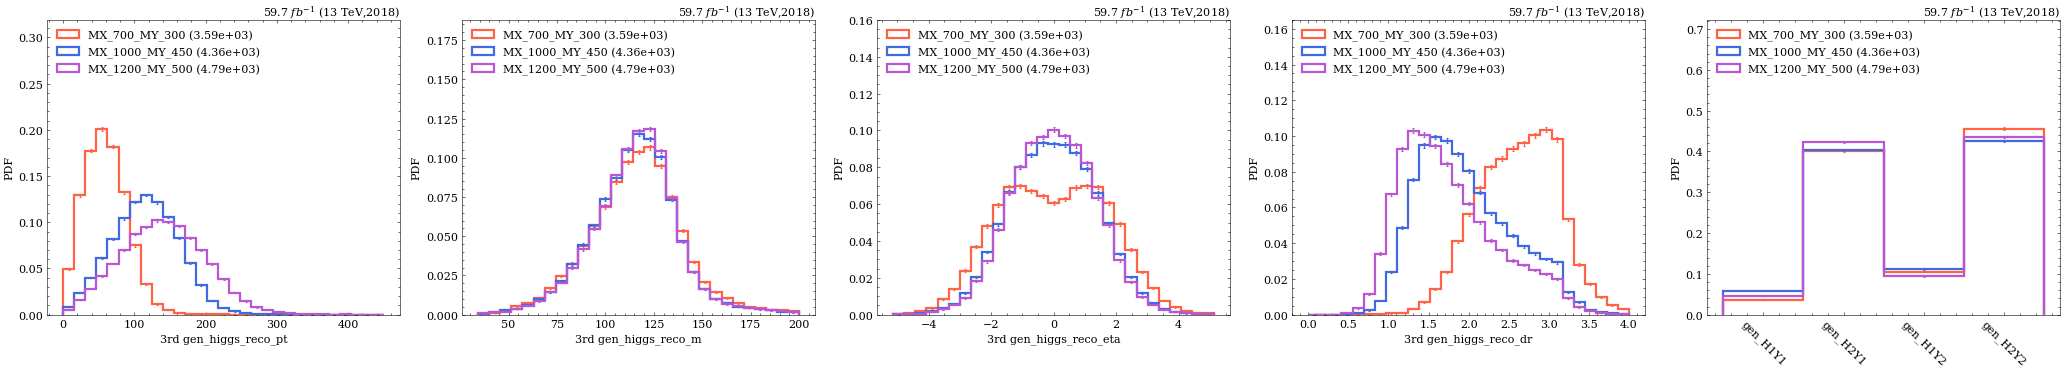

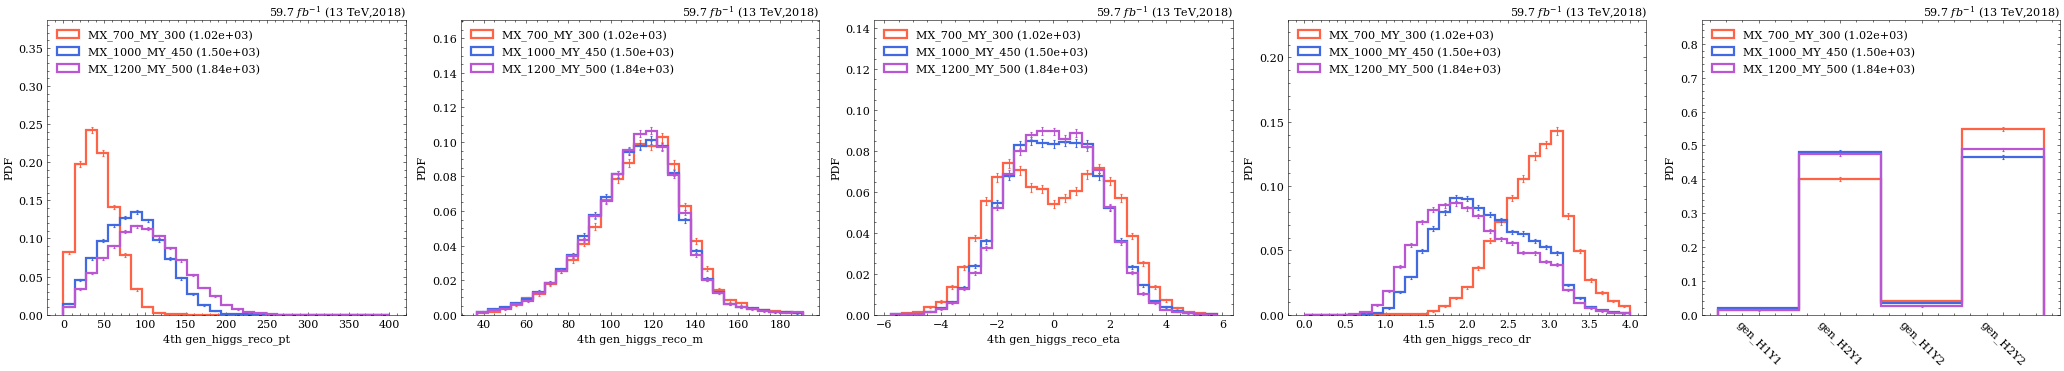

In [15]:
varlist = ['reco_pt','reco_m','reco_eta','reco_dr','id']

ptmax = [500,500,450,400]
for i, higgs in enumerate(higgslist):
    study.quick(
        signal_trees,legend=True,
        masks=lambda t : t.gen_higgs_reco_matched[:,i],
        varlist=[f'gen_higgs_{var}[:,{i}]' for var in varlist],
        binlist=[(0,ptmax[i],30), None, None, (0,4,30)],
        efficiency=True,
        dim=(-1,len(varlist)),
        saveas=f'{dout}/{ordinal(i)}_pt_reco_higgs'
    )

100%|██████████| 4/4 [00:00<00:00, 17.02it/s]


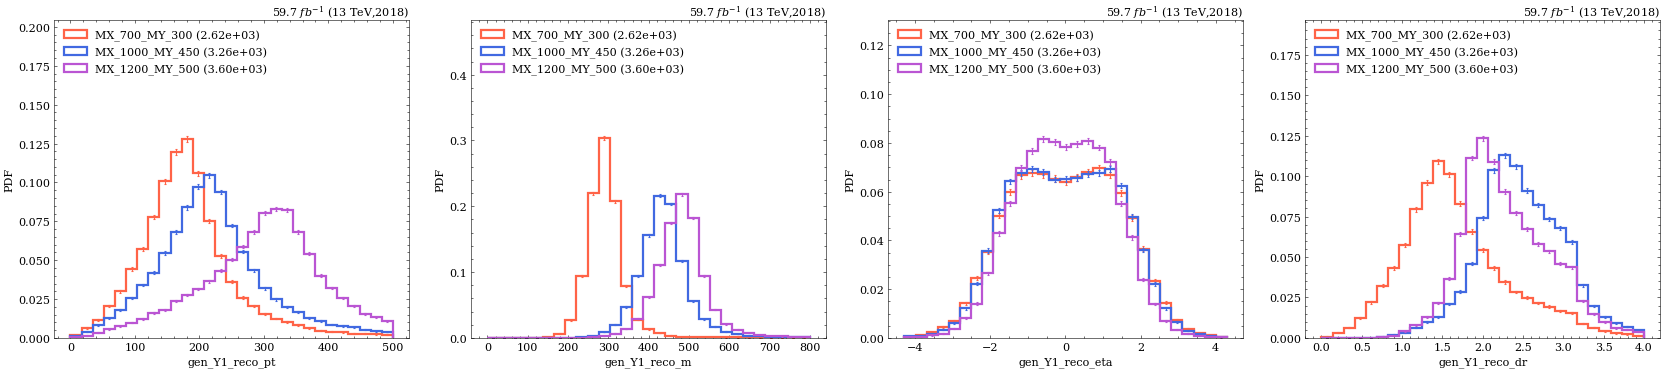

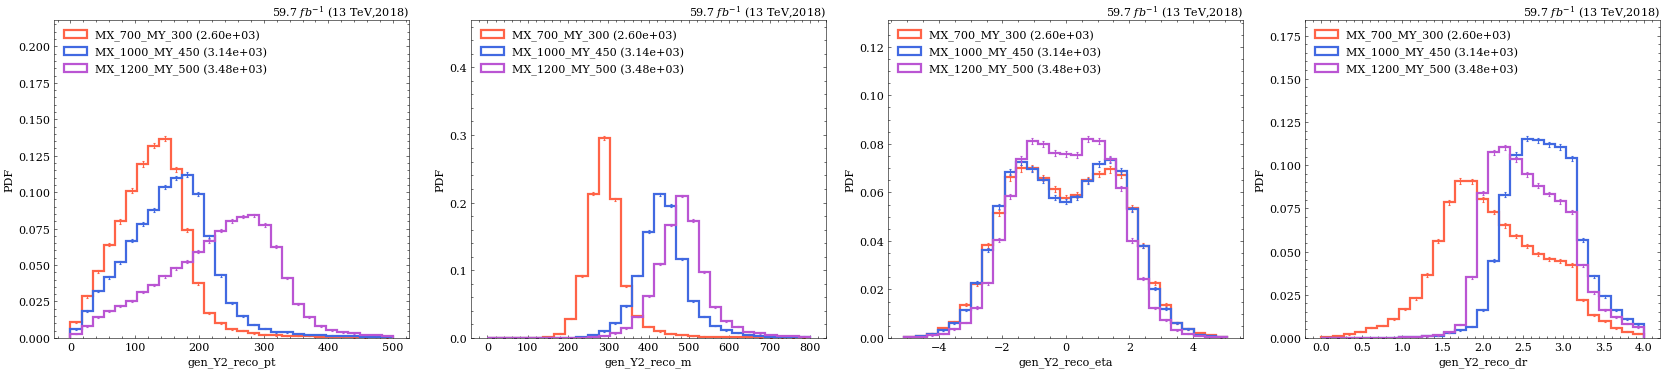

In [45]:
varlist = ['reco_pt','reco_m','reco_eta','reco_dr']

ptmax = [500,500,450,400]
for i, y in enumerate(ylist):
    study.quick(
        signal_trees,legend=True,
        masks=lambda t : t[f"gen_Y{i+1}_reco_matched"],
        varlist=[f'gen_Y{i+1}_{var}' for var in varlist],
        binlist=[(0,ptmax[i],30), (0,800,30), None, (0,4,30)],
        efficiency=True,
        dim=(-1,len(varlist)),
        saveas=f'{dout}/{ordinal(i)}_pt_reco_y'
    )

100%|██████████| 4/4 [00:00<00:00, 19.56it/s]


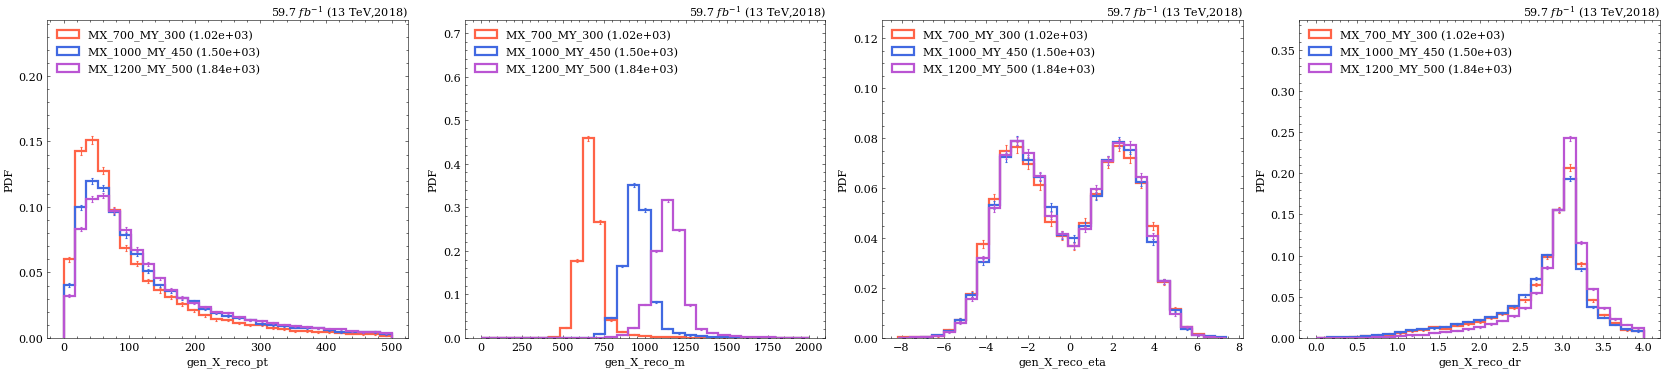

In [46]:
varlist = ['reco_pt','reco_m','reco_eta','reco_dr']

study.quick(
    signal_trees,legend=True,
    masks=lambda t : t[f"gen_X_reco_matched"],
    varlist=[f'gen_X_{var}' for var in varlist],
    binlist=[(0,500,30), (0,2000,30), None, (0,4,30)],
    efficiency=True,
    dim=(-1,len(varlist)),
    saveas=f'{dout}/X_reco'
)

100%|██████████| 1/1 [00:00<00:00, 24.28it/s]


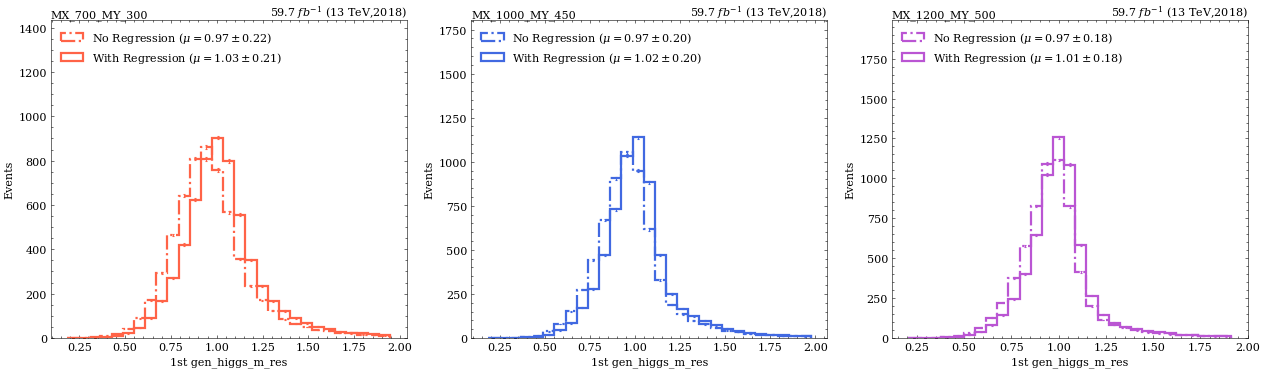

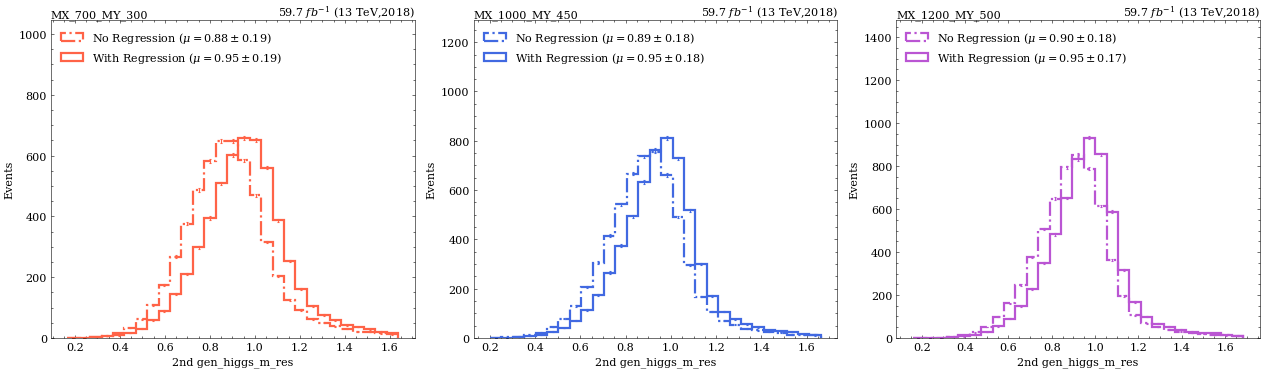

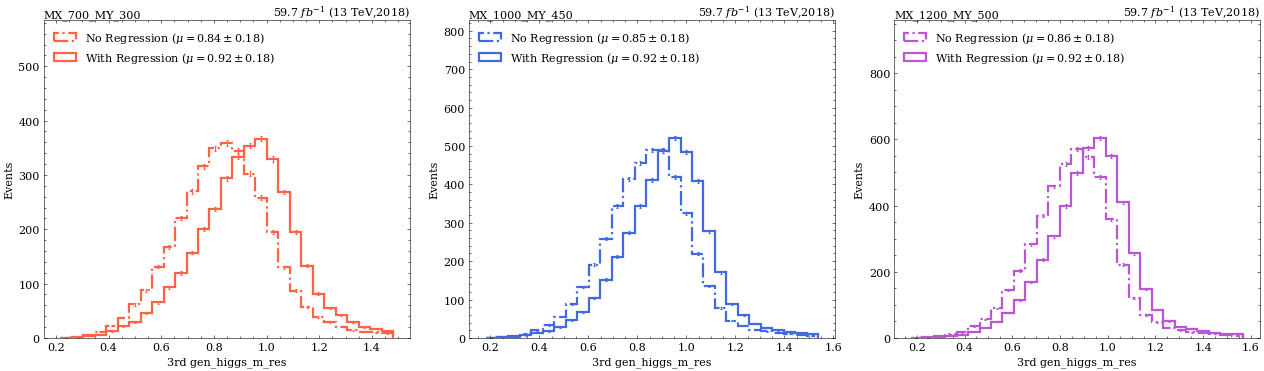

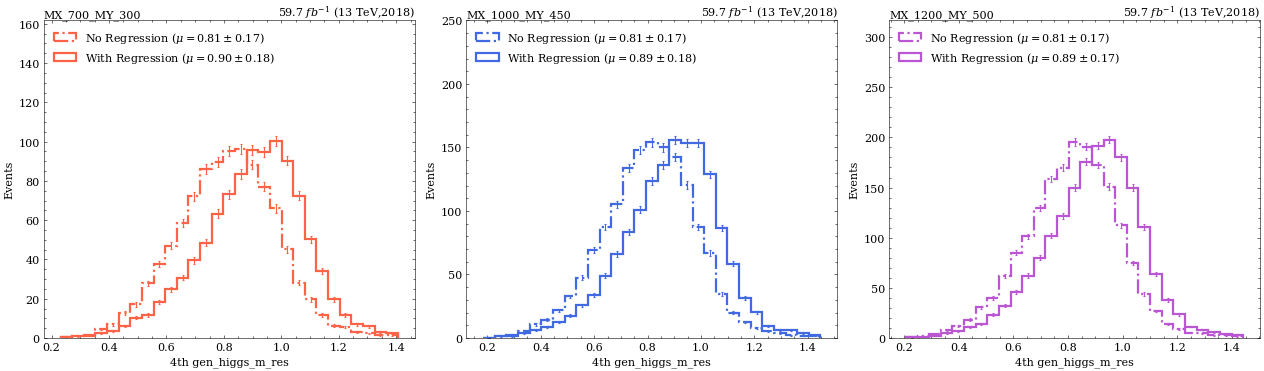

In [62]:
for resonance in range(4):
    fig, ax = study.get_figax(nvar=3, dim=-1)
    for i in range(3):
        study.quick( 
            signal_trees_no_reg[[i]]+signal_trees[[i]],
            legend=True, h_label_stat='mean_stdv',
            h_linestyle=['-.','-',],
            label=["No Regression","With Regression"],
            masks=lambda t : t[f"gen_higgs_reco_matched[:,{resonance}]"],
            varlist=[f'gen_higgs_m_res[:,{resonance}]'],
            text=(0.0,1.0, signal_trees[i].sample),
            text_style=dict(ha='left',va='bottom'),
            figax=(fig,ax.flat[i])
        )
    study.save_fig(fig, saveas=f'{dout}/{ordinal(resonance)}_pt_reco_higgs_m_res')

100%|██████████| 1/1 [00:00<00:00, 22.75it/s]


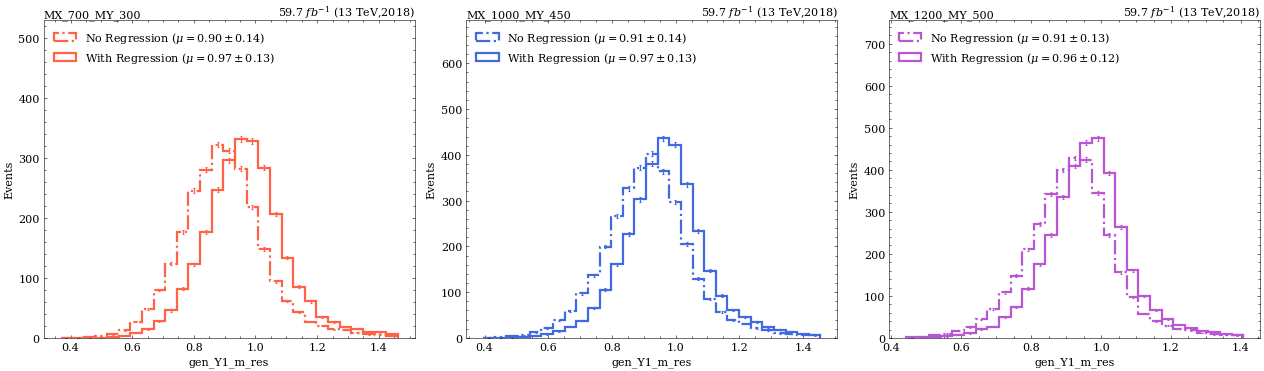

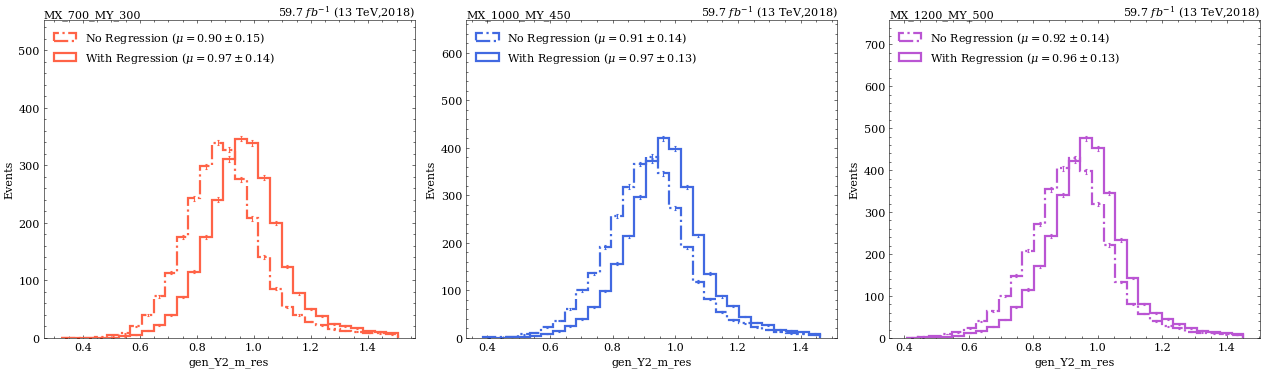

In [63]:
for resonance in eightb.ylist:
    fig, ax = study.get_figax(nvar=3, dim=-1)
    for i in range(3):
        study.quick( 
            signal_trees_no_reg[[i]]+signal_trees[[i]],
            legend=True, h_label_stat='mean_stdv',
            h_linestyle=['-.','-',],
            label=["No Regression","With Regression"],
            masks=lambda t : t[f"gen_{resonance}_reco_matched"],
            varlist=[f'gen_{resonance}_m_res'],
            text=(0.0,1.0, signal_trees[i].sample),
            text_style=dict(ha='left',va='bottom'),
            figax=(fig,ax.flat[i])
        )
    study.save_fig(fig, saveas=f'{dout}/{resonance}_reco_m_res')

100%|██████████| 1/1 [00:00<00:00, 25.31it/s]


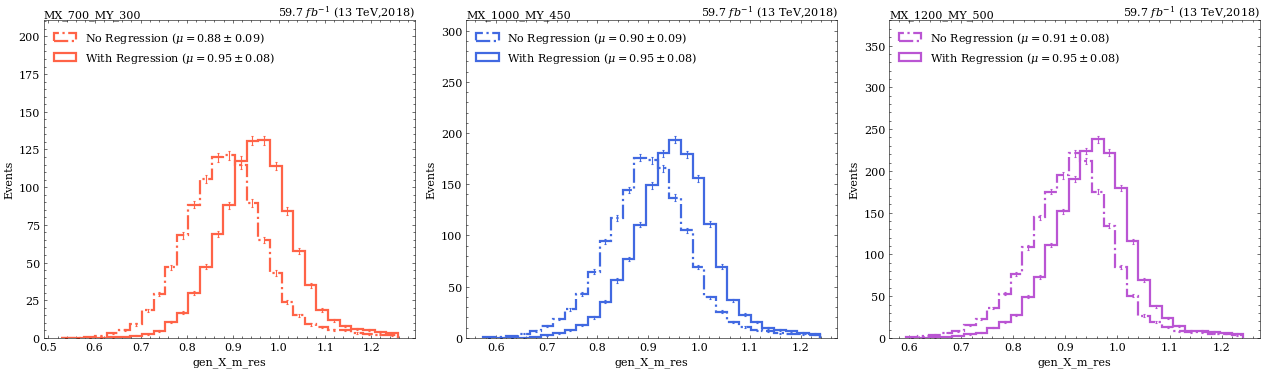

In [64]:
fig, ax = study.get_figax(nvar=3, dim=-1)
for i in range(3):
    study.quick( 
        signal_trees_no_reg[[i]]+signal_trees[[i]],
        legend=True, h_label_stat='mean_stdv',
        h_linestyle=['-.','-',],
        label=["No Regression","With Regression"],
        masks=lambda t : t[f"gen_X_reco_matched"],
        varlist=[f'gen_X_m_res'],
        text=(0.0,1.0, signal_trees[i].sample),
        text_style=dict(ha='left',va='bottom'),
        figax=(fig,ax.flat[i])
    )
study.save_fig(fig, saveas=f'{dout}/X_reco_m_res')

100%|██████████| 1/1 [00:00<00:00, 23.27it/s]


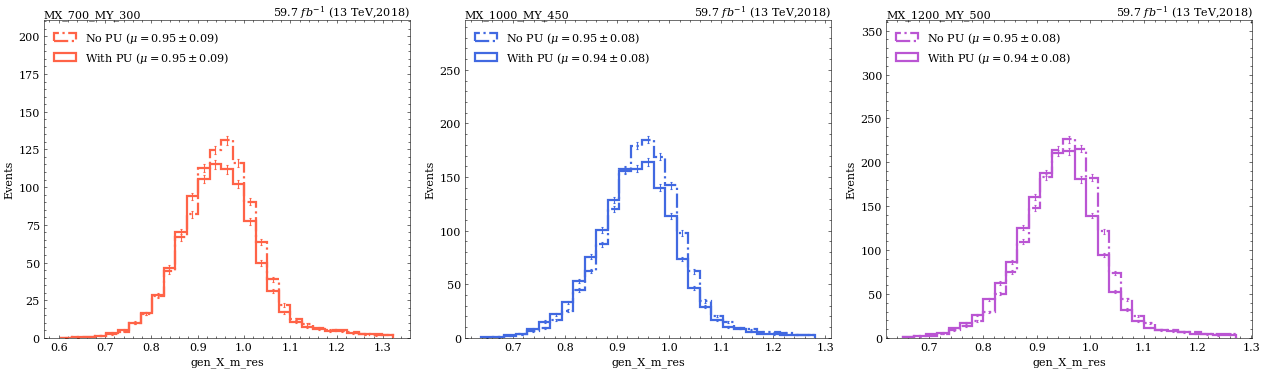

In [65]:
fig, ax = study.get_figax(nvar=3, dim=-1)
for i in range(3):
    study.quick( 
        signal_trees[[i]]+signal_trees_pu[[i]],
        legend=True, h_label_stat='mean_stdv',
        h_linestyle=['-.','-',],
        label=["No PU","With PU"],
        masks=lambda t : t[f"gen_X_reco_matched"],
        varlist=[f'gen_X_m_res'],
        text=(0.0,1.0, signal_trees[i].sample),
        text_style=dict(ha='left',va='bottom'),
        figax=(fig,ax.flat[i])
    )
study.save_fig(fig, saveas=f'{dout}/X_reco_m_res_pu')